In [1]:
import morphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

/usr/local/anaconda/envs/morphs/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# try to find nice block used below, else use last one found
for block_path in morphs.paths.blocks():
    if 'Pen01_Lft_AP2500_ML750__Site04_Z2300__B1101_cat_P01_S04_3' in block_path:
        break

In [3]:
pair_df = morphs.load.pop_pair_df()

/usr/local/anaconda/envs/morphs/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


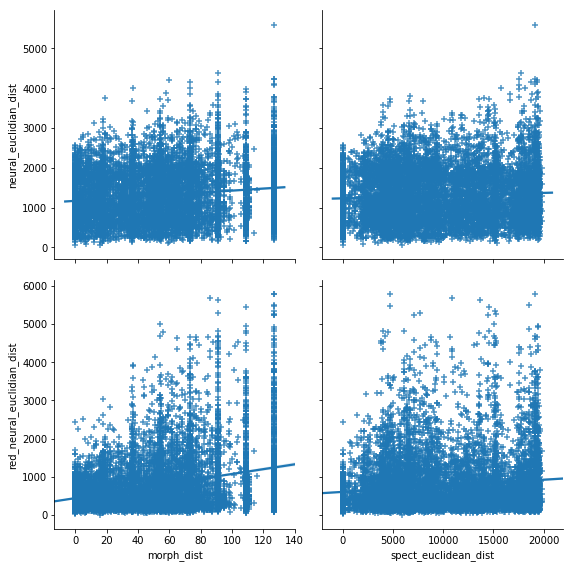

In [4]:
g = sns.pairplot(pair_df.sample(10000), 
                 y_vars=['neural_euclidian_dist', 'red_neural_euclidian_dist'],
                 x_vars=['morph_dist', 'spect_euclidean_dist'],
#                  hue='morph_dim',
                 markers='+',
                 kind='reg',
                 height=4)

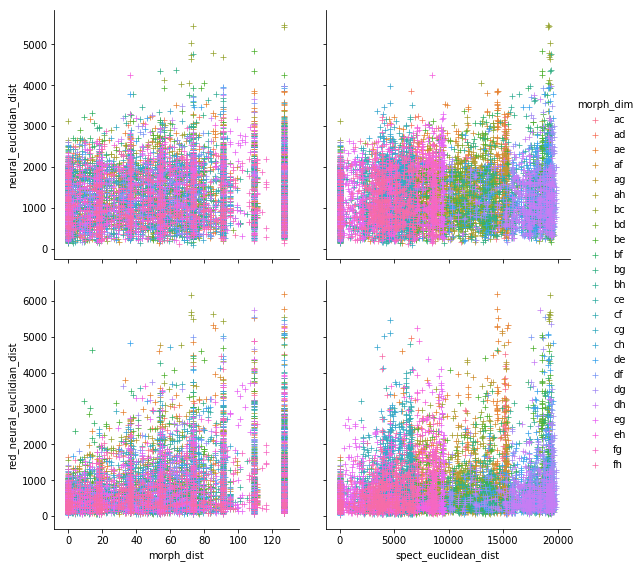

In [5]:
g = sns.pairplot(pair_df.sample(10000), 
                 y_vars=['neural_euclidian_dist', 'red_neural_euclidian_dist'],
                 x_vars=['morph_dist', 'spect_euclidean_dist'],
                 hue='morph_dim',
                 markers='+',
#                  kind='reg',
                 height=4)

Things to note:
 1. 24 dim representation of neural activity seems to remove much of the noise as seen by the left side of the plots
 2. different morphs had different spectrogram distances between the endpoints